In [ ]:
!pip install -q -U albumentations

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.utils.data import DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from utils import scores, save_plot, class2rgb
from tqdm import tqdm
import os 
import matplotlib.pyplot as plt 
from google.colab import drive, files
import numpy as np

from unet import UNet
from dataset import Carla
drive.mount("/content/gdrive")

print(torch.cuda.is_available())

%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 71 kB/s 
Mounted at /content/gdrive
True


In [ ]:
class Network:
  def __init__(self, model, train_data, val_data, learning_rate, batch, device, save_path, loss):
    self.model = model
    self.learning_rate = learning_rate 
    self.DEVICE = DEVICE
    self.train_data = train_data
    self.val_data = val_data
    self.batch_size = batch
    self.save_path = save_path
    self.channels = 13

    self.log_dir = self.save_path + "logs"
    self.writer = SummaryWriter(self.log_dir)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
    self.loss_function = nn.CrossEntropyLoss()
    self.dice_loss = loss
    self.scaler = torch.cuda.amp.GradScaler()
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.1)


    self.L = []
    self.L_val = []
    self.acc_train = []
    self.acc_val = []

  def accuracy(self, y, output):
    batch_acc = []
    for idx in range(y.shape[0]):
      batch_acc.append(((y[idx] == output[idx]).sum() / y[idx].flatten().shape[0]).cpu().numpy())

    return np.mean(batch_acc)

  def save_img(self,output,y):
    output = output.argmax(axis = 1)
    idxs = np.random.randint(0,output.shape[0],3)
    imgs = np.hstack((output[idxs[0]].cpu().numpy(),y[idxs[0]].cpu().numpy()))
    for idx in range(2):
      stack = np.hstack((output[idxs[idx+1]].cpu().numpy(),y[idxs[idx+1]].cpu().numpy()))
      imgs = np.vstack((imgs,stack))
    plt.imsave(SAVE_PATH+f'{self.epoch}.png',imgs)
      
  def __save_model(self,state, is_best):
    if is_best is True:
      torch.save(state, SAVE_PATH + 'BEST_MODEL.pth')
    elif is_best is False:
      torch.save(state, SAVE_PATH + 'LAST_CHECKPOINT.pth')

  def __validation(self):
    self.model.eval()
    epoch_loss = []
    epoch_acc = []
    with torch.no_grad():
      for x,y in self.val_data:
        x = x.float().reshape(self.batch_size,3,150,200).to(device=self.DEVICE)
        y = y.long()[...,0].reshape(self.batch_size,150,200).to(device=self.DEVICE)

        output = self.model(x)
        loss = self.loss_function(output,y) - (1-self.learning_rate) * self.dice_loss(output.argmax(1),y) 

        epoch_loss.append(loss.item())
        epoch_acc.append(self.accuracy(y, output.argmax(axis=1)))
    idx = []
    self.L_val.append(np.mean(epoch_loss))
    self.acc_val.append(np.mean(epoch_acc))

    if self.epoch % 10 == 0:
      self.save_img(output,y)
      
  
  def fit(self, epochs, validation = True):
    for epoch in range(1,epochs+1):
      self.epoch = epoch
      epoch_loss = []
      epoch_acc = []
      loop = tqdm(enumerate(self.train_data), total = len(self.train_data), leave = False)

      self.model.train()

      for batch, (x,y) in loop:

        x = x.float().reshape(self.batch_size,3,150,200).to(device=self.DEVICE)
        y = y.long()[...,0].reshape(self.batch_size,150,200).to(device=self.DEVICE)
        self.optimizer.zero_grad()

        output = self.model(x)
        loss = self.loss_function(output,y) - (1-self.learning_rate) * self.dice_loss(output.argmax(1),y) 


        loss.backward()
        self.optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(self.accuracy(y, output.argmax(axis=1)))


      # UPDATE
      self.L.append(np.mean(epoch_loss))
      self.acc_train.append(np.mean(epoch_acc))
      if validation:
        self.__validation()

      state = {'state_dict' : self.model.state_dict(), 'optimizer': self.optimizer.state_dict()}
      # SAVE MODEL
      if epoch > 10:
        if (self.acc_val[-1] > max(self.acc_val[:-1])):
          self.__save_model(state,True)

        # PLOTS
      if epoch % 10 == 0:
        self.__save_model(state,False)
        save_plot(self.L, self.L_val, 'LOSS', self.save_path)
        save_plot(self.acc_train, self.acc_val, 'ACC', self.save_path)



      # update progress bar
      loop.set_description(f"Epoch [{epoch}/{epochs}]")

      # Update tensorboard
      self.writer.add_scalar('Train loss', self.L[0], epoch)
      self.writer.add_scalar('Validation loss', self.L_val[0], epoch)

    self.writer.close()

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #score = 1 - (score.sum() / num)
        score = score.sum() / num

        return score

if __name__ == '__main__':
  DATASET_PATH = 'gdrive/MyDrive/dataset/'
  DEVICE = "cuda"
  BATCH_SIZE = 32
  LEARNING_RATE = 1e-4
  EPOCHS = 400
  SAVE_PATH = 'gdrive/MyDrive/models/'
  LOSS = DiceLoss()

  transforms = A.Compose([
          A.Rotate(limit=25, p=0.3),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.3),
          A.augmentations.geometric.resize.Resize(150,200),
          ToTensorV2()
  ])
  test_transforms = A.Compose([
          A.Rotate(limit=25, p=0.1),
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.1),
          A.augmentations.geometric.resize.Resize(150,200),
          ToTensorV2()
  ])
  TRAIN_LOADER1 = Carla(DATASET_PATH + 'dataA/', transform = transforms)
  TRAIN_LOADER2 = Carla(DATASET_PATH + 'dataB/', transform = transforms)
  TEST_LOADER = Carla(DATASET_PATH + 'dataC/dataC/', transform = test_transforms)
  VAL_LOADER, TEST_LOADER = torch.utils.data.random_split(TEST_LOADER, [500, 500])

  TRAIN_DATASET = DataLoader(dataset = ConcatDataset([TRAIN_LOADER1, TRAIN_LOADER2]),batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
  VAL_DATASET = DataLoader(dataset = VAL_LOADER,batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
  TEST_DATASET = DataLoader(dataset = VAL_LOADER,batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

  MODEL = UNet(3,13).to(device=DEVICE)
  MODEL.load_state_dict(torch.load(SAVE_PATH + 'BEST_MODELv1' + '.pth')['state_dict'])


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


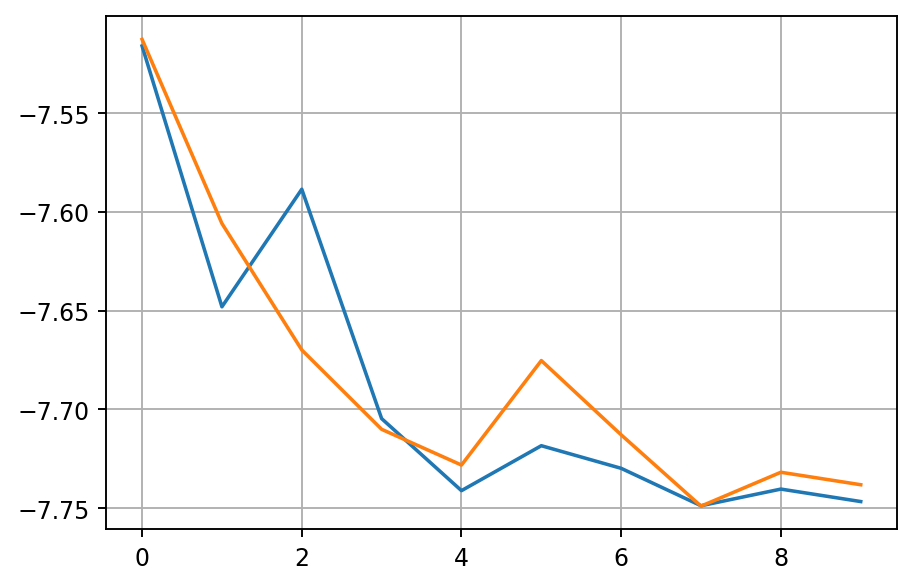

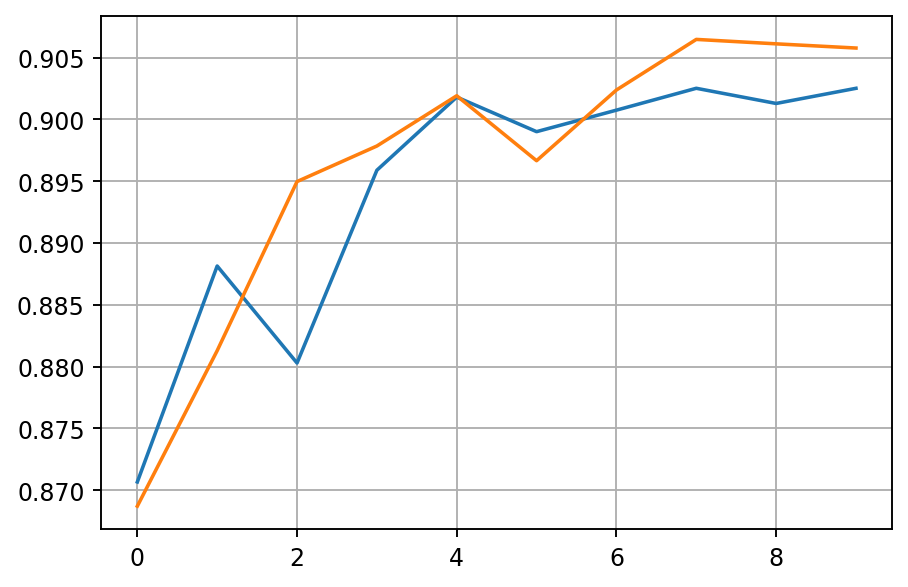

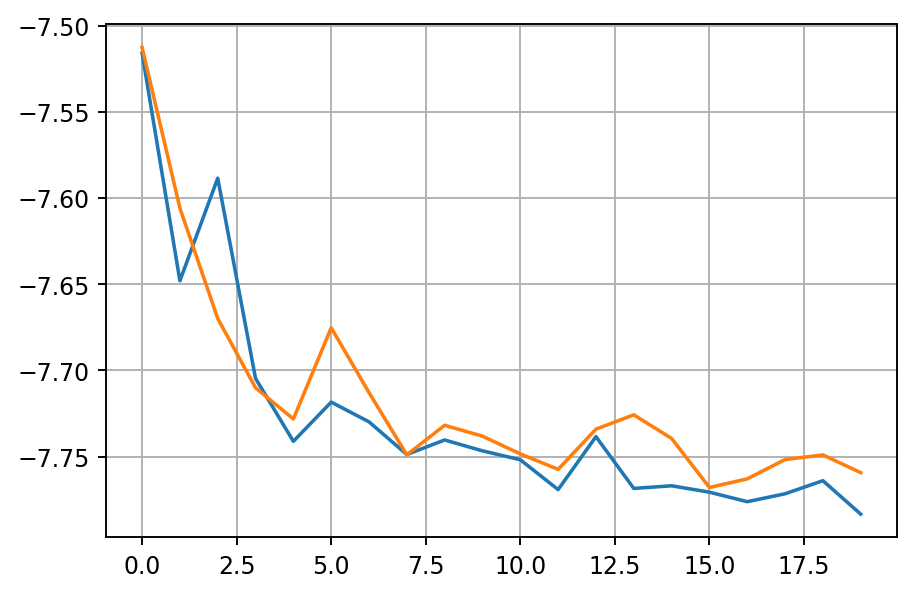

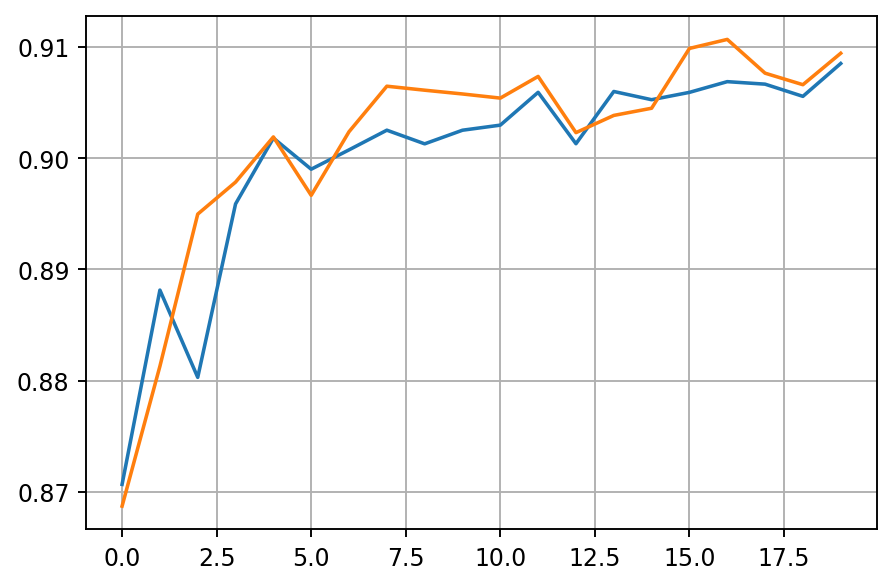

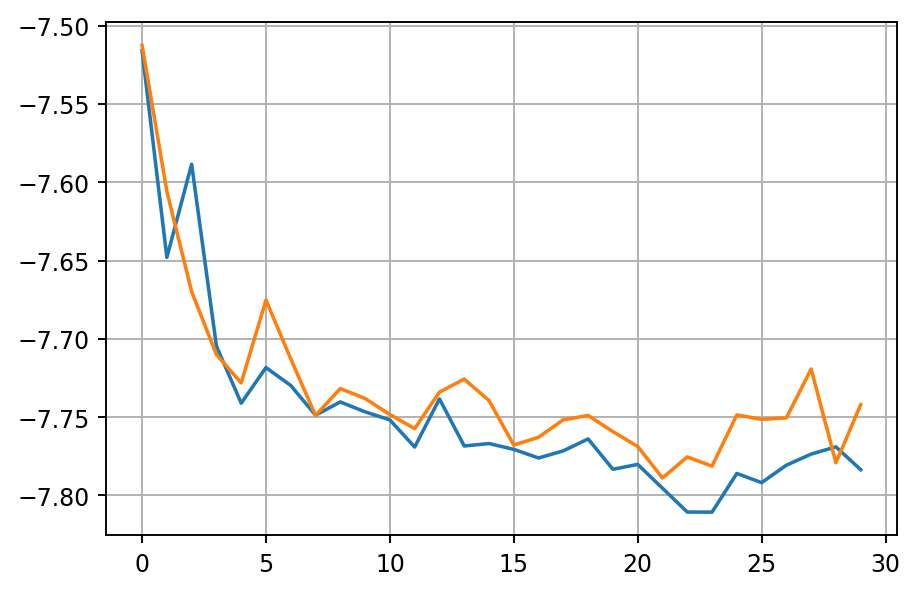

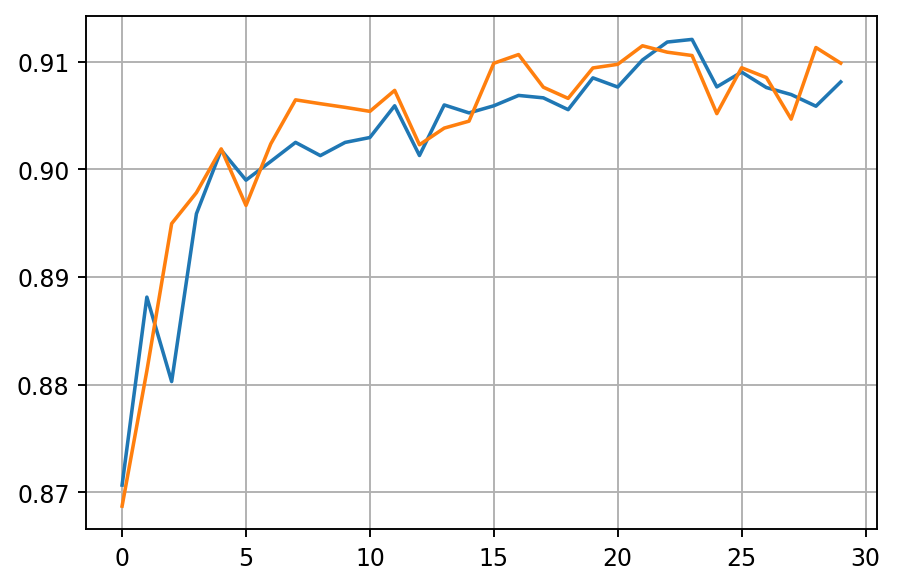

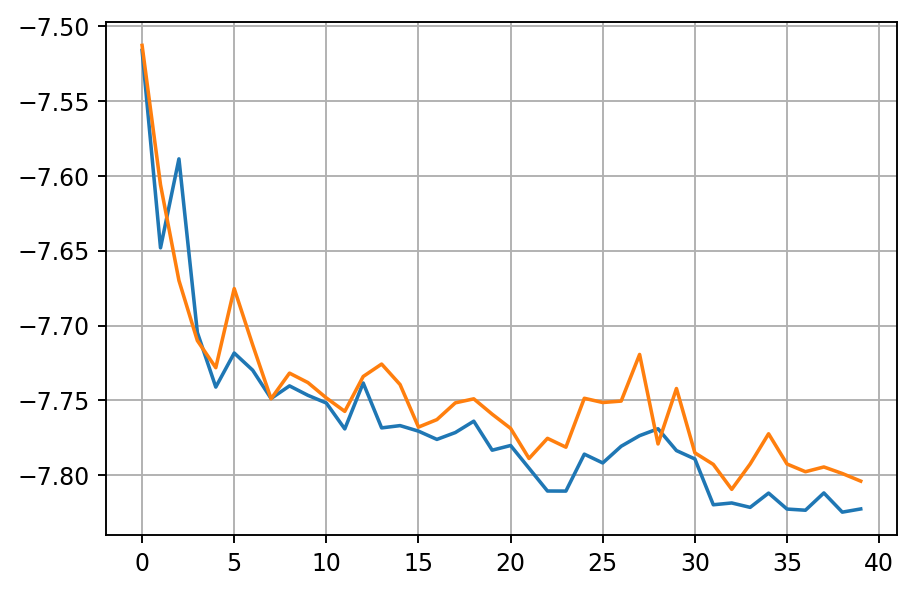

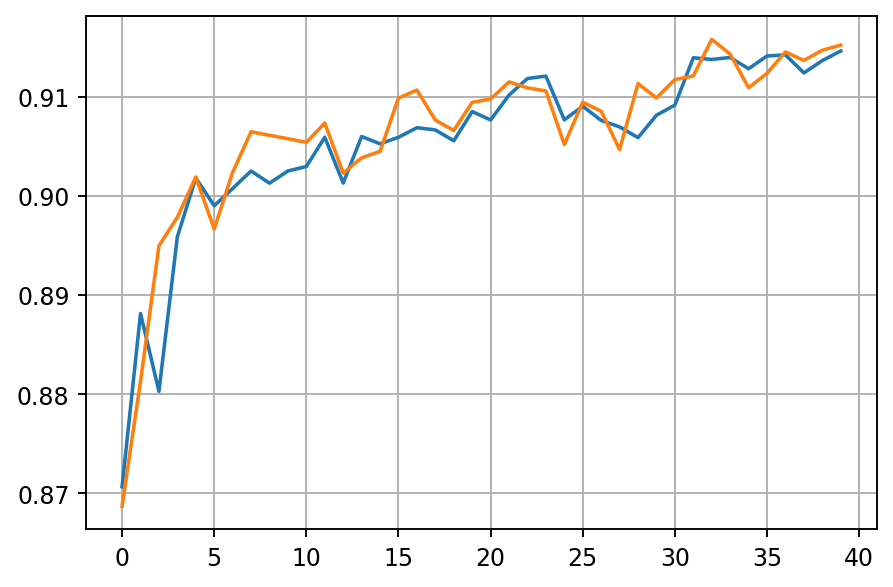

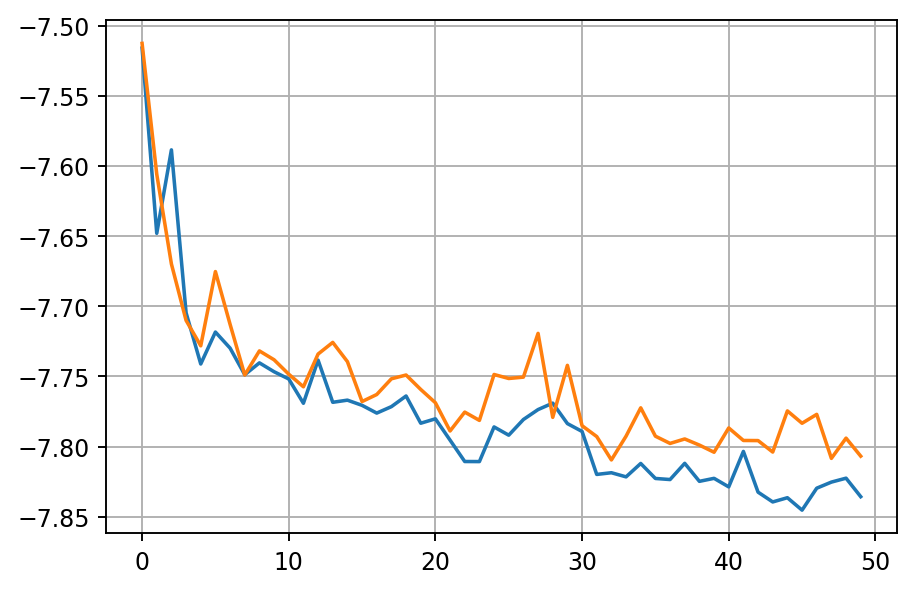

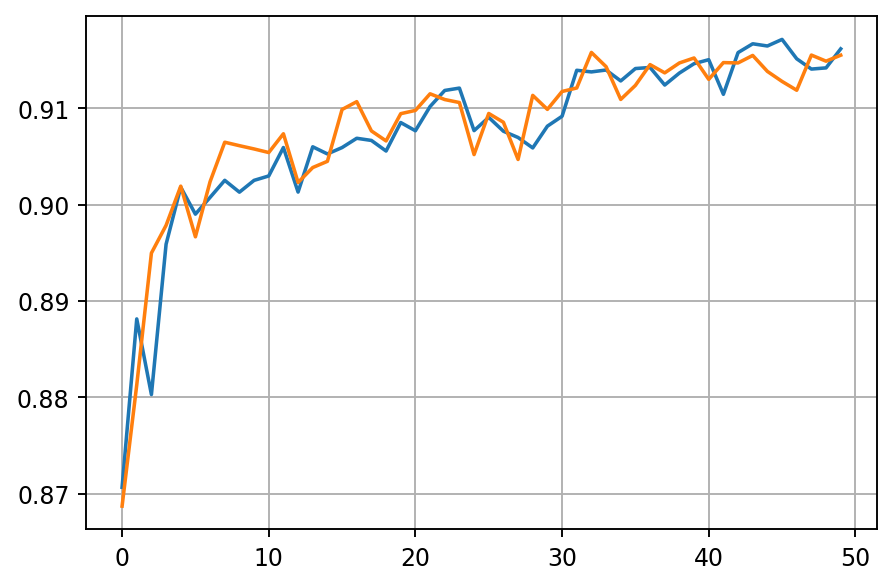

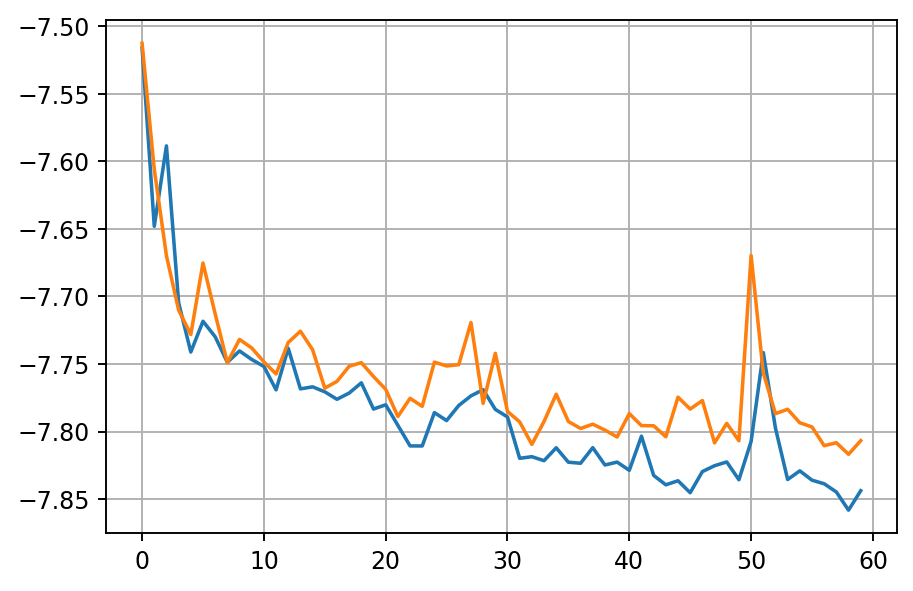

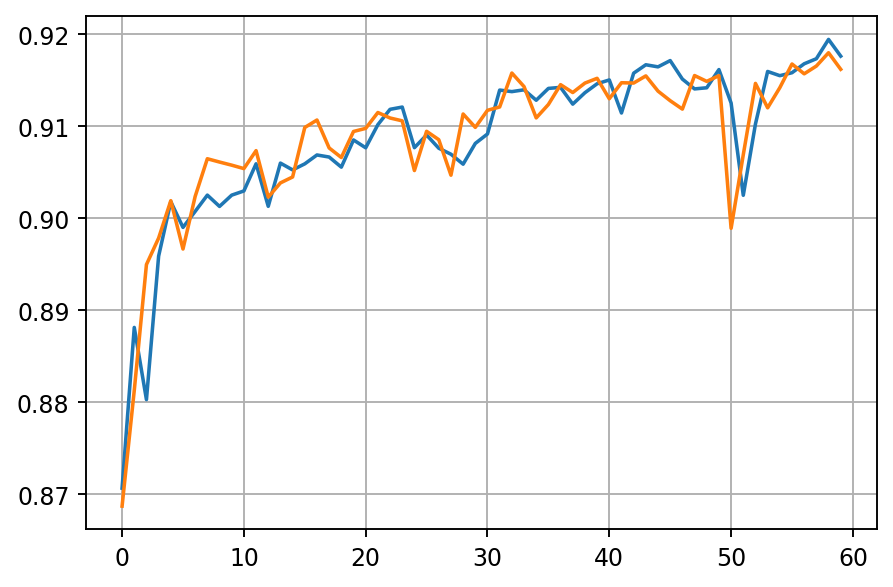

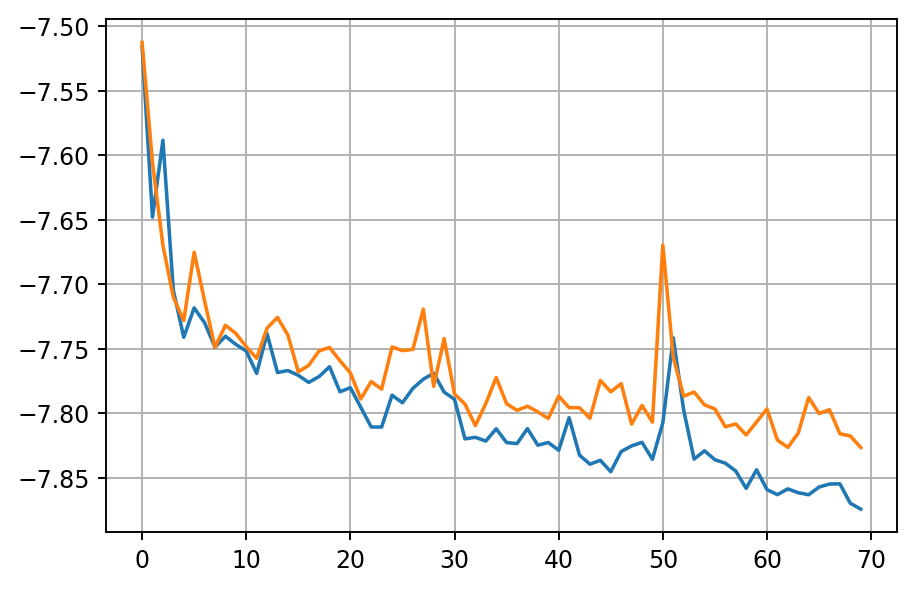

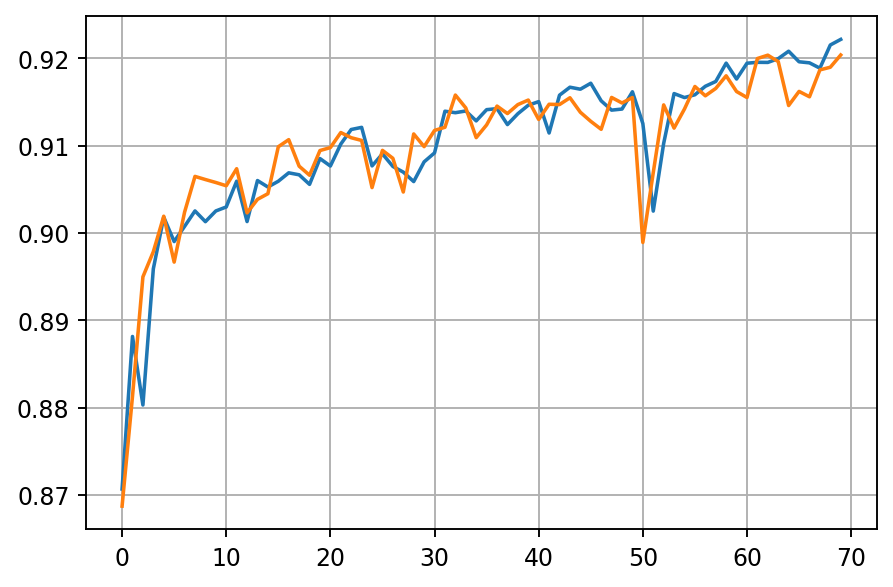

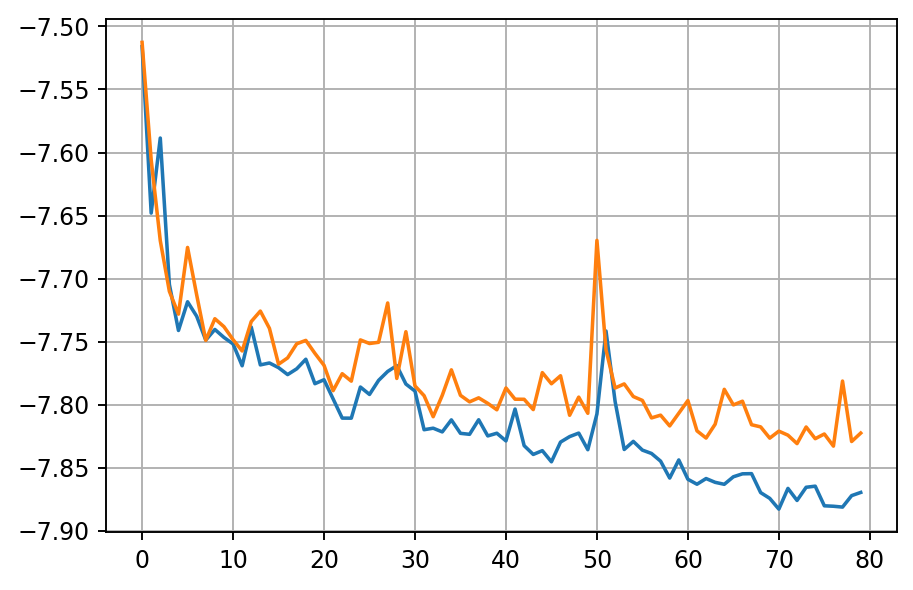

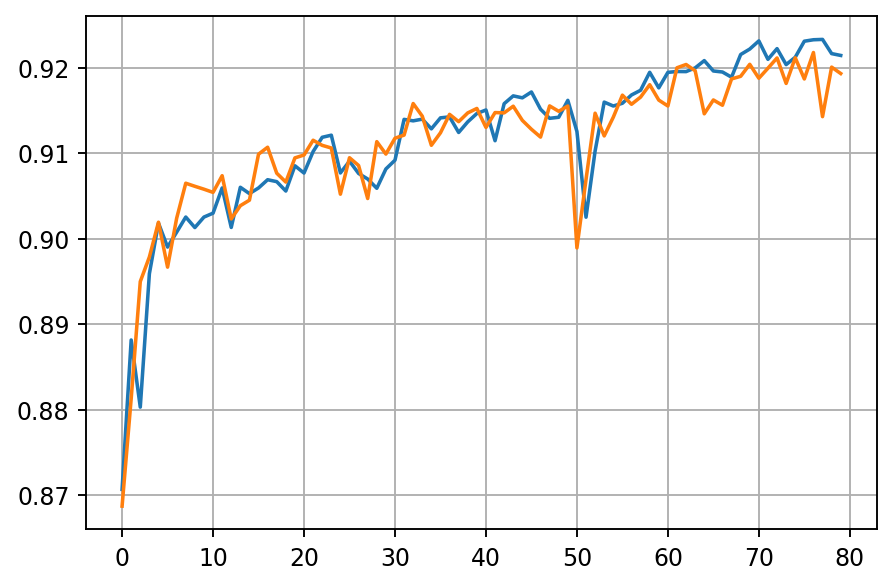

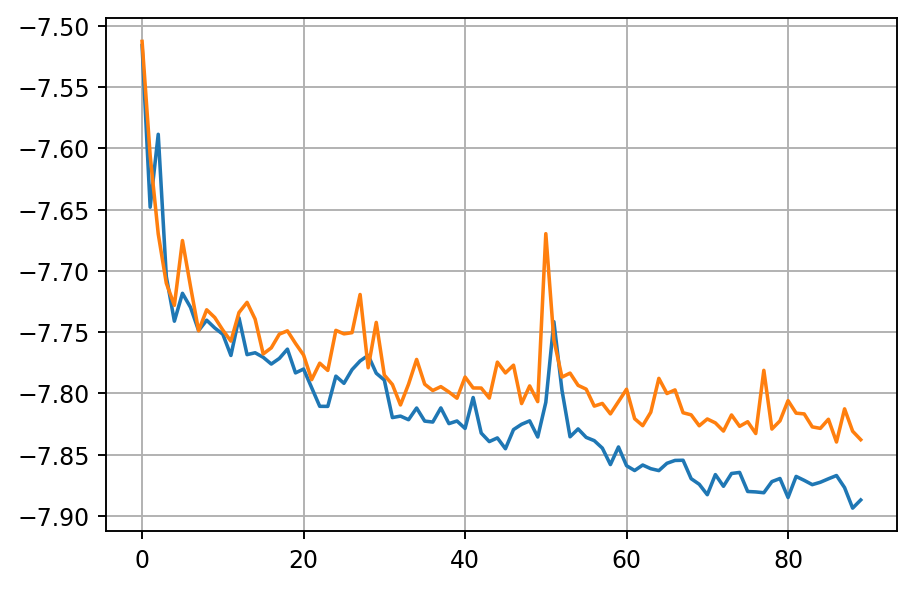

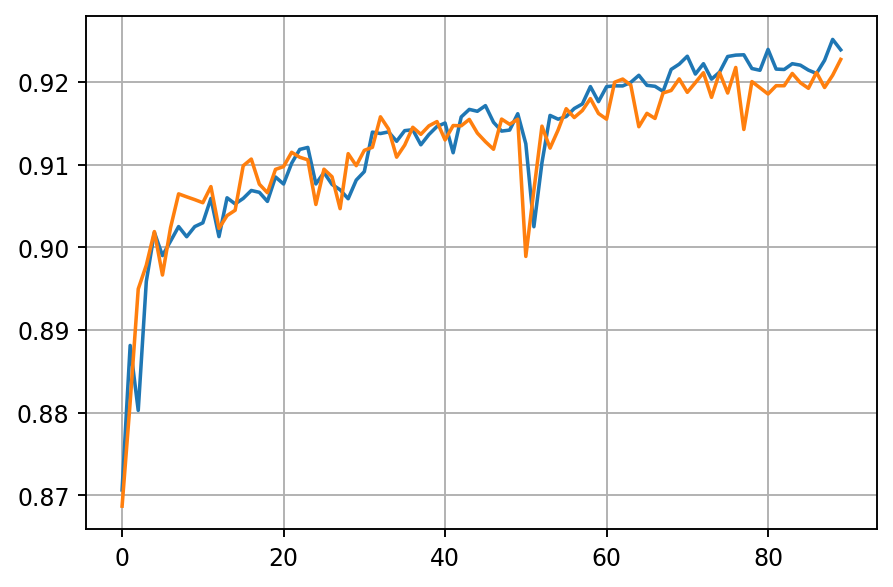

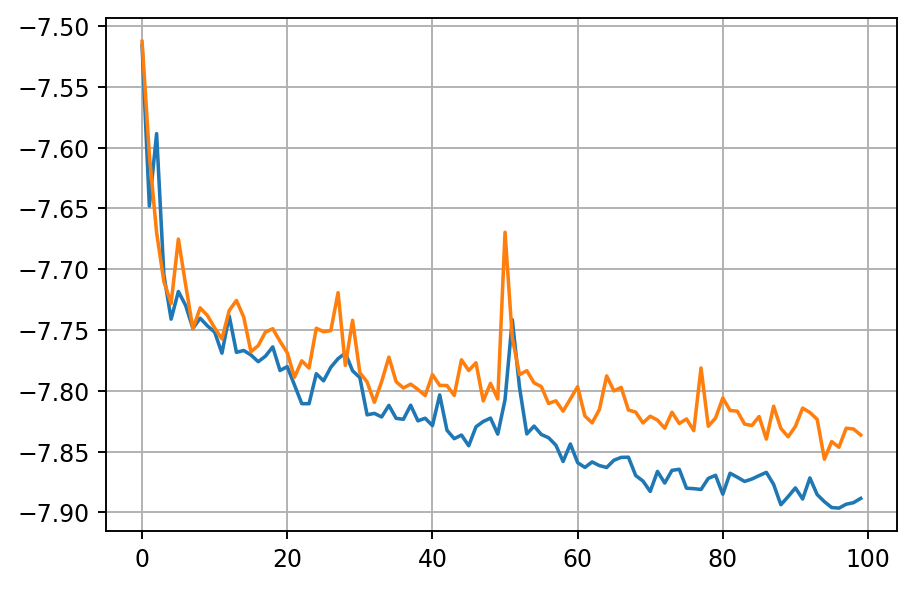

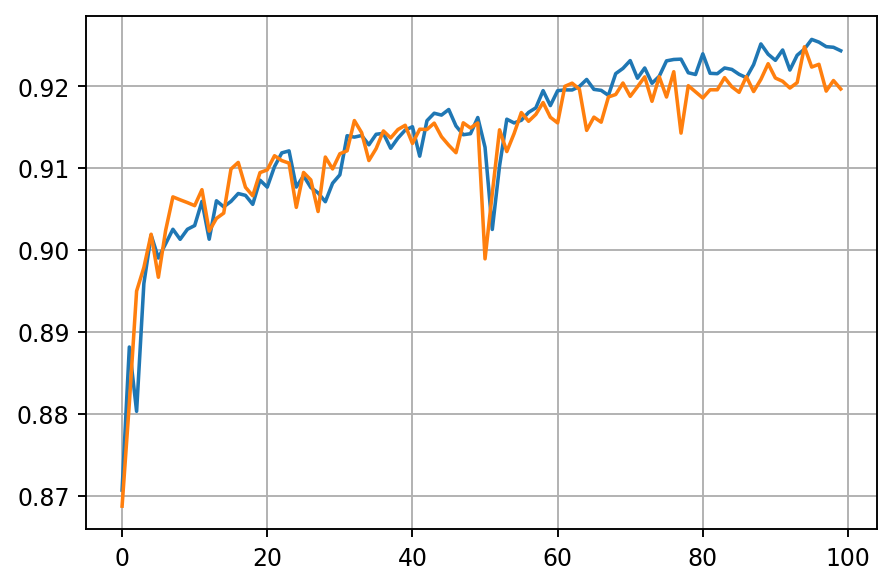

In [ ]:
NET = Network(model = MODEL, 
                train_data = TRAIN_DATASET,
                val_data = VAL_DATASET,
                learning_rate=LEARNING_RATE, 
                batch=32, 
                device = DEVICE,
                save_path = SAVE_PATH,
                loss = LOSS
                )

NET.fit(epochs=EPOCHS)